In [1]:
from utils.RobotConfig import RobotConfig
from utils.ObstacleSpheres import ObsConfig
import casadi
import pinocchio as pin
from pinocchio import casadi as cpin
import numpy as np

In [2]:
Ntp = 10

In [3]:
config_file = 'config/SimpleConfig.yaml'
q_waypoints = np.array([[0, np.pi/4, 0, 0, 0, 0], 
                    [-np.pi/6, np.pi/12, np.pi/6, -np.pi/6, -np.pi/3, -np.pi/3],
                    [-np.pi/4, np.pi/4, np.pi/3, 0, -np.pi/6, -np.pi/2]])

obs = ObsConfig(config_file)
obs.spheres_from_robot(q0 = q_waypoints[0].astype(float).tolist())  # Get initial robot obstacle spheres
obs.spheres_from_env()

Robot = RobotConfig(config_file)
Robot.homePosition = q_waypoints[0]
ngc = Robot.model.nq   # Number of joints
ndof = Robot.model.nv   # Number of DOF
nx = 2*ngc    # Number of states
cx = casadi.SX.sym("x", 2*ngc, 1)
ctau = casadi.SX.sym("tau", ndof, 1)
cacc = cpin.aba(Robot.cmodel, Robot.cdata, cx[:ngc], cx[ngc:], ctau) # Forward dynamics

# Joint limits
Robot.lowerVelocityLimit = np.pi/2 * np.array([-1, -1, -1, -1, -1, -1])  # rad/s
Robot.upperVelocityLimit = np.pi/2 * np.array([1, 1, 1, 1, 1, 1])
Robot.lowerTorqueLimit = 100 * np.array([-1, -1, -1, -1, -1, -1]) 
Robot.upperTorqueLimit = 100 * np.array([1, 1, 1, 1, 1, 1])

q0 = q_waypoints[0]
qT = q_waypoints[-1]
tau0 = pin.rnea(Robot.model, Robot.data, q0, np.zeros(ndof), np.zeros(ndof))
tauT = pin.rnea(Robot.model, Robot.data, qT, np.zeros(ndof), np.zeros(ndof))
print(tau0)
print(tauT)

Feq = casadi.Function(
    "Dyn",
    [cx, ctau],
    [casadi.vertcat(cx[ngc:], cacc)],
)

_,_,p0 = Robot.forward_kinematics(q0)
print(p0)

[  0.         -36.08572402  -9.26563407   0.97299901  -0.09997149
   0.        ]
[ 8.88178420e-16 -2.17616448e+01  5.05844512e+00  1.31084531e+00
 -1.18267539e-01  0.00000000e+00]
[ 0.50734912  0.2329     -0.48584621]


In [4]:
# Verify collision spheres
"""
print(f"Should be equal: \nFrom robot kinematics: {Robot.update_robot_spheres(obs.robot_spheres, q0)} \nFrom cuRobo: {obs.spheres_from_robot_in_world(q0)}")
print(f"Should be equal: \nFrom robot kinematics: {Robot.update_robot_spheres(obs.robot_spheres, qT)} \nFrom cuRobo: {obs.spheres_from_robot_in_world(qT)} ")
"""

'\nprint(f"Should be equal: \nFrom robot kinematics: {Robot.update_robot_spheres(obs.robot_spheres, q0)} \nFrom cuRobo: {obs.spheres_from_robot_in_world(q0)}")\nprint(f"Should be equal: \nFrom robot kinematics: {Robot.update_robot_spheres(obs.robot_spheres, qT)} \nFrom cuRobo: {obs.spheres_from_robot_in_world(qT)} ")\n'

### Collision Sphere Generation

In [5]:
cq = casadi.SX.sym('q', ngc)
get_obstacle_distances = casadi.Function(
    'get_obstacle_distances', 
    [cq], 
    [casadi.vertcat(*Robot.obstacle_distances(cq, obs.env_spheres, obs.robot_spheres))]
    )

# test
print(get_obstacle_distances(q_waypoints[0]))
dis = Robot.obstacle_distances(q_waypoints[0], obs.env_spheres, obs.robot_spheres)
print(Robot.collision_status(q_waypoints[0], obs.env_spheres, obs.robot_spheres))  # False is not collision

[0.506406, 0.507656, 0.13896, 0.11161, 0.53628, 0.51073, 0.382141, 0.355791, 0.236684, 0.210558, 0.162566, 0.135792, 0.29527, 0.268296, 0.487714, 0.45757, 0.55931, 0.532809, 0.0878578, 0.0820592, 0.0171016, 0.0155516, 0.0349966, 0.0350466, 0.013704, 0.0131297, 0.00661331, 0.00708758, 0.059984, 0.0583612, 0.00673741, 0.00678741, 0.0137376, 0.0190118, 0.0224433, 0.0222933, 0.0574821, 0.0338721, 0.0400413, 0.0250313, 0.0669526, 0.0302874, 0.060101, 0.0389336, 0.0510731, 0.0695379, 0.0594359, 0.0743007, 0.0548564, 0.0566721, 0.0423789, 0.065268, 0.0941239, 0.0964688]
False


In [6]:
from utils.Lagrange import *
from utils.LGL_collocation import LGL_collocation
from utils.LocalChart import *

Np = q_waypoints.shape[0]-1  # Number of phase (dersired waypoints: N+1)
T = Np*Ntp  # Number of total collocation points / optimization variables

LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp)
DL,_ = differentiation_matrix(Ntp, LGL_Pts)

LGL = LGL_collocation(Ntp, ngc, ndof)
StatesDiff, StateDiff, LocalsDiff, LocalDiff= LGL.getDiffFuncs()

### Initial Guesses

In [7]:
t_initial = 2
ini_collo_pts = t_initial/2 * (LGL_Pts+1)
ini_q = np.full((Ntp, ngc), 0.0)
ini_x = [None] * T
ini_u = [None] * T


for k in range(Np):
    for j in range(Ntp):
        ini_q[j,:] = q_waypoints[k] + ini_collo_pts[j]/t_initial * (q_waypoints[k+1]-q_waypoints[k])

    ini_dq = np.array([np.squeeze(StateDiff(casadi.vertcat(*ini_q), t_initial, DL[i,:])) for i in range(Ntp)])
    ini_ddq = np.array([np.squeeze(StateDiff(casadi.vertcat(*ini_dq), t_initial, DL[i,:])) for i in range(Ntp)])
    ini_tau = np.array([pin.rnea(Robot.model, Robot.data, ini_q[i], ini_dq[i], ini_ddq[i]) for i in range(Ntp)])  # M@ddq + C@dq + G
    
    for j in range(Ntp):
        t = k*Ntp + j
        ini_x[t] =  np.concatenate([ini_q[j],ini_dq[j]])
        ini_u[t] = np.array(ini_tau[j])
        print(f"Collision State {t}: {Robot.collision_status(ini_q[j], obs.env_spheres, obs.robot_spheres)}")

    #print(Robot.forward_kinematics(ini_q[5,:]))
    #print(Robot.forward_kinematics(ini_q[6,:]))



Collision State 0: False
Collision State 1: False
Collision State 2: False
Collision State 3: True
Collision State 4: False
Collision State 5: False
Collision State 6: False
Collision State 7: False
Collision State 8: False
Collision State 9: False
Collision State 10: False
Collision State 11: False
Collision State 12: False
Collision State 13: True
Collision State 14: True
Collision State 15: True
Collision State 16: False
Collision State 17: False
Collision State 18: False
Collision State 19: False


### Nonlinear Programming Problem (NLP)

In [8]:
opti = casadi.Opti()
# Optimization variables
var_xs = [opti.variable(2*ngc) for _ in range(T)]
var_us = [opti.variable(ndof) for _ in range(T)]
var_deltaT = [opti.variable(1) for _ in range(Np)]

# Constraints
for i in range(Np):
    opti.subject_to(var_deltaT[i] >= 0.0)

    for tp in range(Ntp):
        t = i*Ntp + tp
        # dynamics
        opti.subject_to(StatesDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[tp,:]) 
                        == Feq(var_xs[t], var_us[t]))
        
        # joint constraints
        opti.subject_to(var_xs[t][:ngc] <= Robot.upperPositionLimit)
        opti.subject_to(var_xs[t][:ngc] >= Robot.lowerPositionLimit)
        # joint velocity constraints
        opti.subject_to(var_xs[t][ngc:] <= Robot.upperVelocityLimit)
        opti.subject_to(var_xs[t][ngc:] >= Robot.lowerVelocityLimit)
        # torque constraints
        opti.subject_to(var_us[t] <= Robot.upperTorqueLimit)
        opti.subject_to(var_us[t] >= Robot.lowerTorqueLimit)

        # collision avoidance
        opti.subject_to(get_obstacle_distances(var_xs[t][:ngc]) >= 1e-04)

# waypoints constraints (N-1 middle waypoints)
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp][:ngc] == q_waypoints[i])

# continuity
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp-1] == var_xs[i*Ntp])
    opti.subject_to(var_us[i*Ntp-1] == var_us[i*Ntp])

# continuity of derivatives
for i in range(Np-1):
    opti.subject_to(StatesDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[Ntp-1,:]) 
                    == StatesDiff(casadi.vertcat(*var_xs[(i+1)*Ntp: (i+2)*Ntp]), var_deltaT[i+1], DL[0,:]))
    
    opti.subject_to(LocalDiff(casadi.vertcat(*var_us[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[Ntp-1,:])
                   == LocalDiff(casadi.vertcat(*var_us[(i+1)*Ntp: (i+2)*Ntp]), var_deltaT[i], DL[0,:]))


# boundary conditions
opti.subject_to(var_xs[0][:ngc] == q0)
opti.subject_to(var_xs[-1][:ngc] == qT)
opti.subject_to(var_xs[0][ngc:] == 0)
opti.subject_to(var_xs[-1][ngc:] == 0)
#opti.subject_to(var_us[0] == tau0)
#opti.subject_to(var_us[-1] == tauT)

# Objective
totalcost = 0

R = np.eye(ndof)
for i in range(Np):
    for tp in range(Ntp):
        var_xs_Phase = var_xs[i*Ntp: (i+1)*Ntp]
        dq = [dq_Phase[ngc:] for dq_Phase in var_xs_Phase]
        ddq = StateDiff(casadi.vertcat(*dq), var_deltaT[i], DL[tp,:])
        totalcost += var_deltaT[i]/2 * LGL_Wts[tp] * casadi.mtimes([ddq.T, R, ddq])
        
    totalcost += var_deltaT[i]

opti.minimize(totalcost)
opti.solver("ipopt") 


for t in var_deltaT:
    opti.set_initial(t, t_initial)
for t in range(T):
    opti.set_initial(var_xs[t], ini_x[t])
    opti.set_initial(var_us[t], ini_u[t])

In [9]:
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_us = [opti.value(var_u) for var_u in var_us]
    sol_T = [opti.value(var_t) for var_t in var_deltaT]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:     5256
Number of nonzeros in inequality constraint Jacobian.:     4042
Number of nonzeros in Lagrangian Hessian.............:     5882

Total number of variables............................:      362
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      306
Total number of inequality c

   1  5.8490801e+00 6.57e+00 5.17e+00  -1.0 3.86e+00    -  7.05e-01 4.81e-01f  1
   2  8.3472894e+00 3.95e+00 3.87e+01  -1.0 4.81e+00    -  1.50e-01 5.06e-01f  1
   3  1.0237084e+01 2.44e+00 5.19e+01  -1.0 4.14e+00    -  1.61e-01 4.54e-01f  1
   4  1.1103233e+01 8.86e-01 7.96e+01  -1.0 5.53e-01   0.0 9.16e-01 6.26e-01f  1
   5  1.9827875e+01 1.78e+00 2.17e+02  -1.0 4.23e+00  -0.5 1.94e-01 9.45e-01f  1
   6  2.8756850e+01 1.01e+01 1.77e+03  -1.0 6.66e+00  -1.0 6.86e-02 8.28e-01f  1
   7  2.3020770e+01 1.22e+01 5.36e+02  -1.0 1.66e+00   0.4 1.07e-01 1.00e+00f  1
   8  2.4584296e+01 5.74e+00 6.68e+01  -1.0 2.98e+00  -0.1 6.96e-01 1.00e+00h  1
   9  2.8893067e+01 1.96e+00 2.16e+02  -1.0 1.81e+00  -0.6 4.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.8072548e+01 2.13e+00 8.50e+01  -1.0 4.89e-01  -0.2 8.71e-01 1.00e+00f  1
  11  3.4939437e+01 1.49e+01 3.26e+02  -1.0 3.25e+00  -0.6 4.17e-01 1.00e+00f  1
  12  3.9133006e+01 9.45e+00

In [10]:
print(sol_T)
print(f"Total time: {sum(sol_T)}")
T_List = [0] + [sum(sol_T[:i+1]) for i in range(Np)]

[3.332352083435209, 2.4556973814920093]
Total time: 5.7880494649272185


In [11]:
### Check collision
for t in range(T):
    dis = np.min(np.array(get_obstacle_distances(sol_xs[t][:ngc])))
    print(f"Collision Distance {t}: {dis}, \n State:{Robot.collision_status(sol_xs[t][:ngc], obs.env_spheres, obs.robot_spheres)}")

Collision Distance 0: 0.006613313039108986, 
 State:False
Collision Distance 1: 0.006402246220914556, 
 State:False
Collision Distance 2: 0.0037503077355271284, 
 State:False
Collision Distance 3: 9.999033490566515e-05, 
 State:False
Collision Distance 4: 9.999015084716581e-05, 
 State:False
Collision Distance 5: 0.0005640937008546988, 
 State:False
Collision Distance 6: 0.007351711838964825, 
 State:False
Collision Distance 7: 9.999024008813806e-05, 
 State:False
Collision Distance 8: 0.010827447068953937, 
 State:False
Collision Distance 9: 0.01883235821358429, 
 State:False
Collision Distance 10: 0.018832358213584394, 
 State:False
Collision Distance 11: 0.021366960276132645, 
 State:False
Collision Distance 12: 0.01017918610428381, 
 State:False
Collision Distance 13: 9.999019499981263e-05, 
 State:False
Collision Distance 14: 9.999013654757825e-05, 
 State:False
Collision Distance 15: 0.015230150844141343, 
 State:False
Collision Distance 16: 0.026822006686779552, 
 State:False
Co

### Inverse Dynamics

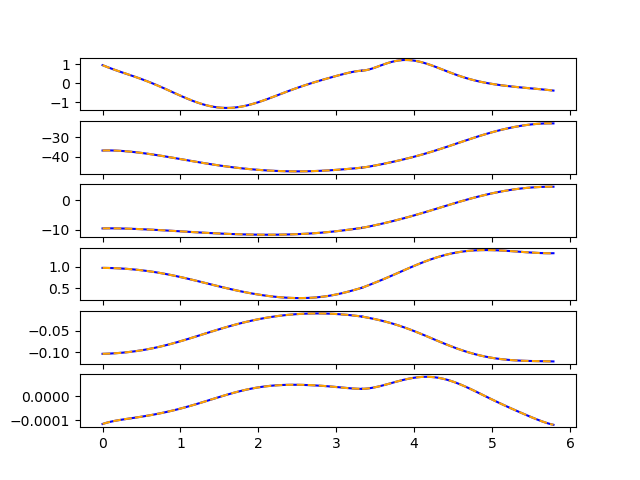

In [12]:
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
nsample = 100
fig, axs = plt.subplots(ngc,1)
for i in range(Np):
    sample_t = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]

    t = casadi.SX.sym("t")
    inter_xs = casadi.Function(
        "xt", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )
    inter_dxs = casadi.Function(
        "dxt", 
        [t], [DiffLangrangeInterpolation(t, collo_pts, sol_xs[i*Ntp: (i+1)*Ntp])]
    )


    sample_q = np.array([np.squeeze(inter_xs(ti)[:ngc]) for ti in sample_t])
    sample_dq = np.array([np.squeeze(inter_xs(ti)[ngc:]) for ti in sample_t])
    sample_ddq = np.array([np.squeeze(inter_dxs(ti)[ngc:]) for ti in sample_t])

    # from interpolation
    sample_u = np.array([np.squeeze(inter_us(ti)) for ti in sample_t])
    
    # from dynamics equations
    tau_id = np.array([pin.rnea(Robot.model, Robot.data, q, dq, ddq) for q, dq, ddq in zip(sample_q, sample_dq, sample_ddq)])
    # plot sample_u and tau
    
    joint_traj = np.concatenate((joint_traj, sample_q), axis=0) if i > 0 else sample_q

    for j in range(ngc): 
        axs[j].plot(sample_t, sample_u[:,j], label=f'u{j}',color='blue')
        axs[j].plot(sample_t, tau_id[:,j], label=f'tau{j}',color='orange',linestyle='dashed')

plt.show()

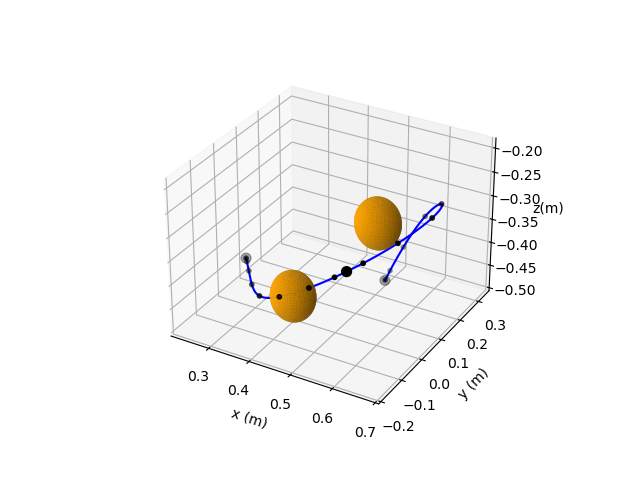

In [13]:
from visualization.plotGeo import *
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

'''
for t in range(T):
    if Robot.collision_status(sol_xs[t][:ngc], obs.env_spheres, obs.robot_spheres) == True:
        sphere_list = Robot.update_robot_spheres(obs.robot_spheres,joint_traj[i])
        plot_robot_spheres(ax, sphere_list, color='purple',alpha=0.5)
        print(t)
        break
'''

tool_traj = np.zeros((joint_traj.shape[0], 3))
for i in range(joint_traj.shape[0]):
    _, _, p = Robot.forward_kinematics(joint_traj[i])
    tool_traj[i] = p


tool_collocation_points = np.zeros((T, 3))
for i in range(T):
    _, _, p = Robot.forward_kinematics(np.array(sol_xs[i][:ngc]))
    tool_collocation_points[i] = p

tool_waypoints = np.zeros((q_waypoints.shape[0], 3))
for i in range(q_waypoints.shape[0]):
    _, _, p = Robot.forward_kinematics(q_waypoints[i])
    tool_waypoints[i] = p


plot_traj(ax, tool_traj, color='blue', axis_label=['x (m)','y (m)','z(m)'])
plot_points(ax, tool_collocation_points, color = 'black', s = 10)
plot_points(ax, tool_waypoints, color='black', s =50)
plot_env_spheres(ax, obs.env_spheres, color='orange',alpha=1)
plt.show()

10


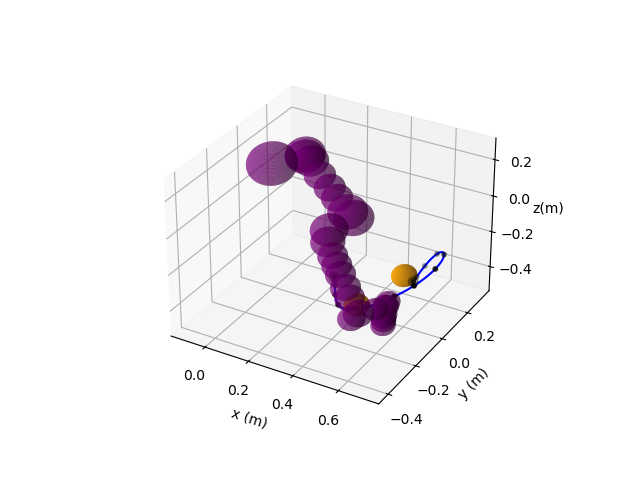

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

t = 10
sphere_list = Robot.update_robot_spheres(obs.robot_spheres,sol_xs[t][:ngc])
plot_robot_spheres(ax, sphere_list, color='purple',alpha=0.5)
print(t)


tool_traj = np.zeros((joint_traj.shape[0], 3))
for i in range(joint_traj.shape[0]):
    _, _, p = Robot.forward_kinematics(joint_traj[i])
    tool_traj[i] = p


tool_collocation_points = np.zeros((T, 3))
for i in range(T):
    _, _, p = Robot.forward_kinematics(np.array(sol_xs[i][:ngc]))
    tool_collocation_points[i] = p

tool_waypoints = np.zeros((q_waypoints.shape[0], 3))
for i in range(q_waypoints.shape[0]):
    _, _, p = Robot.forward_kinematics(q_waypoints[i])
    tool_waypoints[i] = p


plot_traj(ax, tool_traj, color='blue', axis_label=['x (m)','y (m)','z(m)'])
plot_points(ax, tool_collocation_points, color = 'black', s = 10)
plot_points(ax, tool_waypoints, color='black', s =50)
plot_env_spheres(ax, obs.env_spheres, color='orange',alpha=1)
plt.show()